In [ ]:
# импортируем нужные библиотеки
import numpy as np
import pandas as pd
import pandahouse as ph
import seaborn as sns
import hashlib
from scipy import stats

In [ ]:
# подключаемся к нашей базе данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220920',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

# Часть 1: Проверка системы сплитования

У нас есть данные АА-теста с '2022-08-27' по '2022-09-02'. Нужно убедиться, что наша система сплитования работает корректно, и ключевая метрика не отличается между группами не только в конкретно нашем АА-тесте, но и в целом.

Сделаем симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации сформируем подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Проведем сравнение этих подвыборок t-testом.

In [3]:
# посмотрим сколько всего уникальных пользователей пользовались приложением в указаный период
query = """
SELECT uniqExact(user_id)
FROM simulator_20220920.feed_actions
WHERE toDate(time) BETWEEN '2022-08-27' AND '2022-09-02'
"""

ph.read_clickhouse(query, connection=connection)

,uniqExact(user_id)
0,42585


Значит в каждой из 5 групп должно быть приблизительно по 8500 пользователей 

In [4]:
# посмотрим данные по 2 и 3 группе
query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220920.feed_actions 
WHERE toDate(time) between '2022-08-27' and '2022-09-02'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

users = ph.read_clickhouse(query, connection=connection)
users.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [5]:
# количество пользователей действительно около 8500 в каждой группе
users.groupby('exp_group').user_id.count()

exp_group
2    8480
3    8569
Name: user_id, dtype: int64

<AxesSubplot:xlabel='ctr', ylabel='Count'>

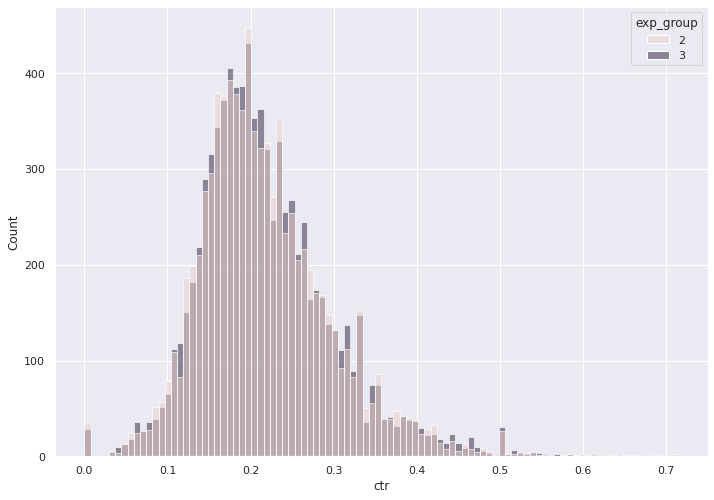

In [6]:
# посмотрим распределение по ключевой метрике на графике для двух групп
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = users,
            x='ctr',
            hue='exp_group',
            alpha=0.5,
            kde=False)

Глядя на график кажется, что распределение по CTR примерно одинаковое

#### Теперь проведем симуляцию 10000 А/А-тестов

За нулевую гипотезу принимаем, что значения CTR в выборках равны

In [7]:
# рассчитаем t-критерий для подвыборок из двух групп
p_values = [stats.ttest_ind(users[users.exp_group == 2].ctr.sample(500),
                            users[users.exp_group == 3].ctr.sample(500),
                            equal_var=False)[1] for i in range(10000)]

<AxesSubplot:ylabel='Count'>

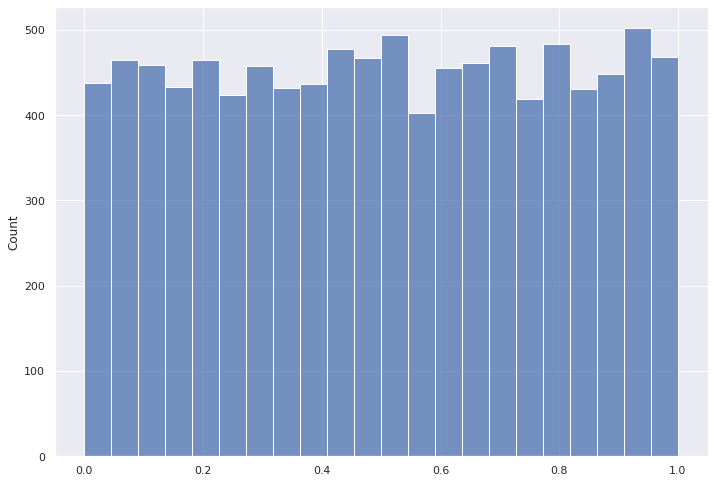

In [8]:
# построим гистограмму распределения получившихся 10000 p-values
sns.histplot(p_values)

#### Посчитаем, какой процент p-values оказался меньше либо равен 0.05

In [9]:
count = 0

for value in p_values:
    if value <= 0.05:
        count += 1
percent = round(count / len(p_values) * 100, 2)

print(f'Меньше либо равными 0.05 оказалось {percent}% p-values')

Меньше либо равными 0.05 оказалось 4.9% p-values


Выходит, что значимые отклонения мы получили меньше чем в 5% случаев. Значит можем считать, что система сплитования работает корректно 

# Часть 2: A/B тест

Нужно проверить результаты эксперимента, который проходил с 2022-09-03 по 2022-09-09 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

### A/A тест

<AxesSubplot:xlabel='ctr', ylabel='Count'>

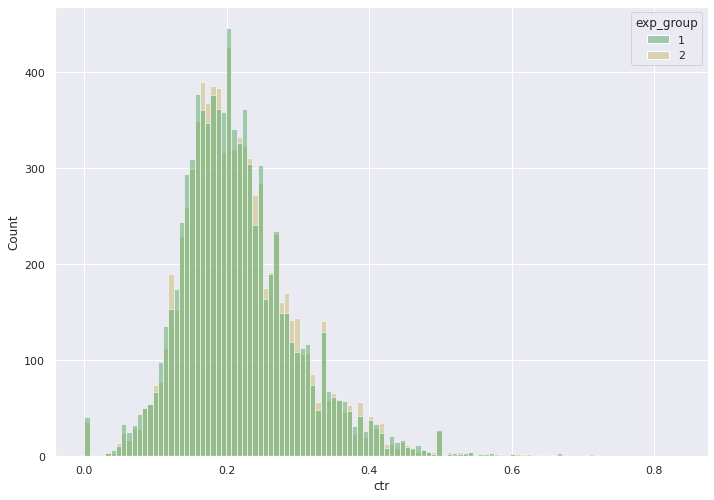

In [3]:
# посмотрим на графике данные по 2 и 1 группе до начала эксперимента, чтобы убедиться, что распределение CTR было одинаковым 
query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220920.feed_actions 
WHERE toDate(time) between '2022-08-27' and '2022-09-02'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

users_aa = ph.read_clickhouse(query, connection=connection)

sns.set(rc={'figure.figsize':(11.7,8.27)}) # поменяем масштаб графика

sns.histplot(data = users_aa,
            x='ctr',
            hue='exp_group',
            palette=['g','y'],
            alpha=0.5,
            kde=False)

In [4]:
# кол-во пользователей в группах приблизительно одинаковое
users_aa.groupby('exp_group').user_id.count()

exp_group
1    8537
2    8480
Name: user_id, dtype: int64

In [5]:
stats.ttest_ind(users_aa[users_aa.exp_group == 1].ctr,
                users_aa[users_aa.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=-2.017208642179426, pvalue=0.043689417475740205)

И по графику, и по результату t-теста можем сделать вывод, что средний CTR в выборках одинаковый

### A/B тест

In [6]:
# выгружаем данные за период проведения теста
query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220920.feed_actions 
WHERE toDate(time) between '2022-09-03' and '2022-09-09'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

users = ph.read_clickhouse(query, connection=connection)

Сравним средние значения CTR до и во время эксперимента

In [7]:
# CTR в группах до начала эксперимента
print('Средний CTR в контрольной группе:', round(users_aa[users_aa.exp_group == 1].ctr.mean(), 3))
print('Средний CTR в экспериментальной группе:', round(users_aa[users_aa.exp_group == 2].ctr.mean(), 3))

Средний CTR в контрольной группе: 0.216
Средний CTR в экспериментальной группе: 0.218


In [8]:
# CTR в группах во время эксперимента
print('Средний CTR в контрольной группе:', round(users[users.exp_group == 1].ctr.mean(), 3))
print('Средний CTR в экспериментальной группе:', round(users[users.exp_group == 2].ctr.mean(), 3))

Средний CTR в контрольной группе: 0.216
Средний CTR в экспериментальной группе: 0.214


На первый взгляд значительных изменений нет

<AxesSubplot:xlabel='ctr', ylabel='Count'>

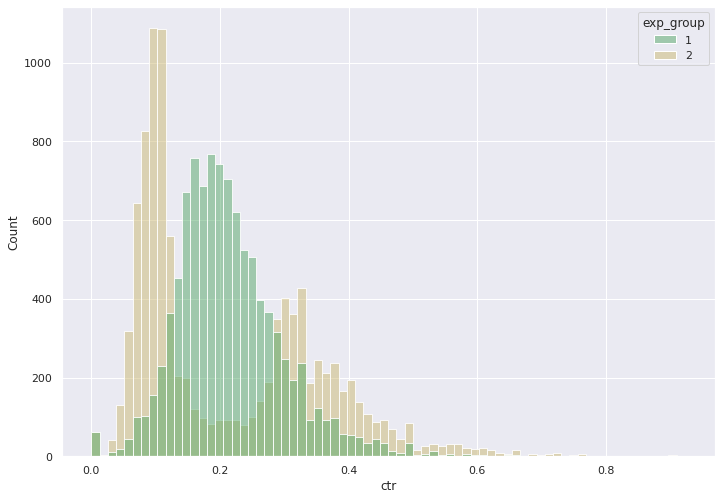

In [9]:
# посмотрим распределение по ключевой метрике на графике для двух групп
sns.histplot(data = users,
            x='ctr',
            hue='exp_group',
            palette=['g','y'],
            alpha=0.5,
            kde=False)

На графике видны явные различия. В экпериментальной группе получили бимодальное распределение – значит часть пользователей стала лайкать посты чаще, другая реже. Проверим результаты с помощью тестов

#### Проверим с помощью t-теста

Из-за бимодального распределения в экспериментальной группе не выполняется условие для t-теста. Но все же посмотрим на результат

За нулевую гипотезу принимаем равенство средних

In [10]:
stats.ttest_ind(users[users.exp_group == 1].ctr,
                users[users.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

По результатам t-теста мы не можем отклонить нулевую гипотезу и высока вероятность того, что средний CTR в выборках отличаться не будет

#### Сравним результат с тестом Манна-Уитни

In [11]:
stats.mannwhitneyu(users[users.exp_group == 1].ctr, 
                   users[users.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Тест Манна-Уитни в отличие от t-теста видит значимые различия

#### Проверим результаты на сглаженном CTR

In [12]:
# функция для сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [13]:
# считаем общегрупповой CTR по контрольной и экспериментальной группе
global_ctr_1 = users[users.exp_group == 1].likes.sum()/users[users.exp_group == 1].views.sum()
global_ctr_2 = users[users.exp_group == 2].likes.sum()/users[users.exp_group == 2].views.sum()

In [14]:
group_1 = users[users.exp_group == 1].copy()
group_2 = users[users.exp_group == 2].copy()

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

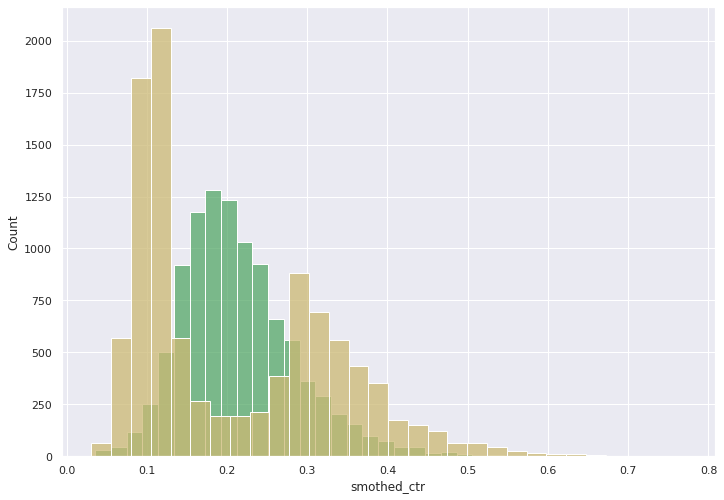

In [15]:
# применим функцию сглаживания
group_1['smothed_ctr'] = users.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group_2['smothed_ctr'] = users.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

# посмотрим на график сглаженного CTR
sns.histplot(group_1.smothed_ctr, color='g',
             kde = False, bins=30)
sns.histplot(group_2.smothed_ctr, color='y',
             kde = False, bins=30)

#### Проведем t-тест и тест Манна-Уитни на сглаженном CTR

In [16]:
stats.ttest_ind(group_1['smothed_ctr'],
                group_2['smothed_ctr'],
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

На сглаженном CTR t-тест позволяет отклонить нулевую гипотезу

In [17]:
stats.mannwhitneyu(group_1['smothed_ctr'], 
                   group_2['smothed_ctr'],
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

#### Пуассоновский бутстреп

In [18]:
# функция бутстрепа
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

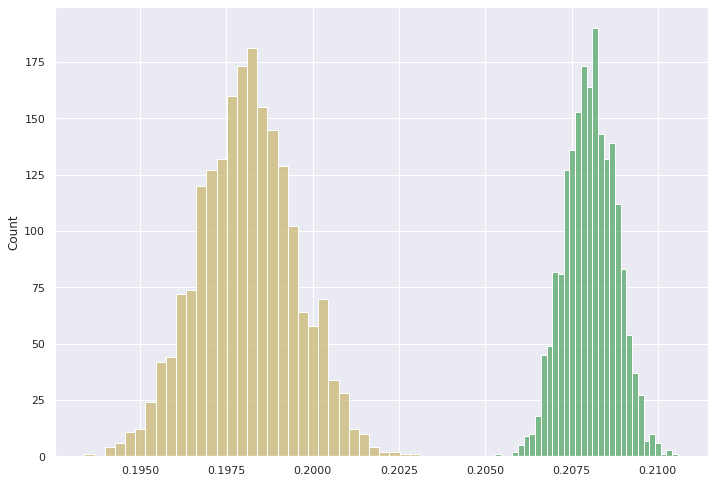

In [19]:
likes1 = users[users.exp_group == 1].likes.to_numpy()
views1 = users[users.exp_group == 1].views.to_numpy()
likes2 = users[users.exp_group == 2].likes.to_numpy()
views2 = users[users.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, color='g')
sns.histplot(ctr2, color='y')

<AxesSubplot:ylabel='Count'>

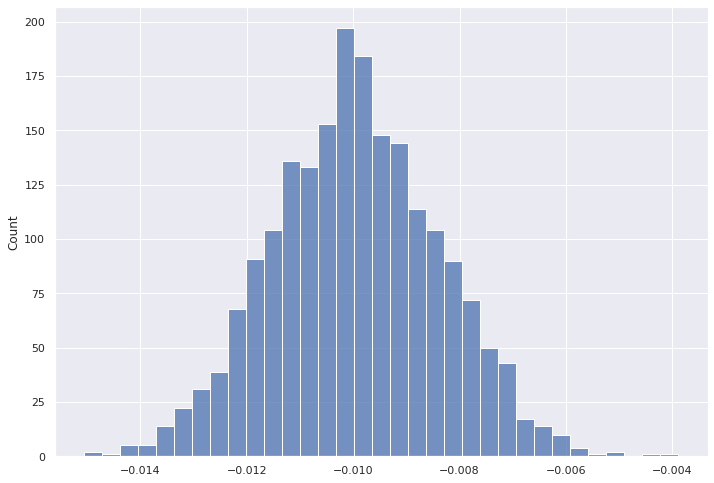

In [20]:
# посмотрим распределение разницы между глобальными CTR
sns.histplot(ctr2 - ctr1)

На графиках видно, что контрольная группа показала значительно лучший результат по CTR, чем экспериментальная группа 

Гистограмма разности не пересекла 0, значит одна группа строго больше другой

#### Тесты поверх бакетного преобразования

In [21]:
# поделим пользователей на 50 бакетов сразу в кликхаусе, приблизительно по 200 пользователей
query = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-09-03' and '2022-09-09'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

users = ph.read_clickhouse(query, connection=connection)
users.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


#### Проведем тест Манна-Уитни и t-тест поверх бакетного преобразования

In [22]:
stats.mannwhitneyu(users[users.exp_group == 1].bucket_ctr, 
                   users[users.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [23]:
stats.ttest_ind(users[users.exp_group == 1].bucket_ctr,
                users[users.exp_group == 2].bucket_ctr,
                equal_var=False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

Оба теста показывают различия

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

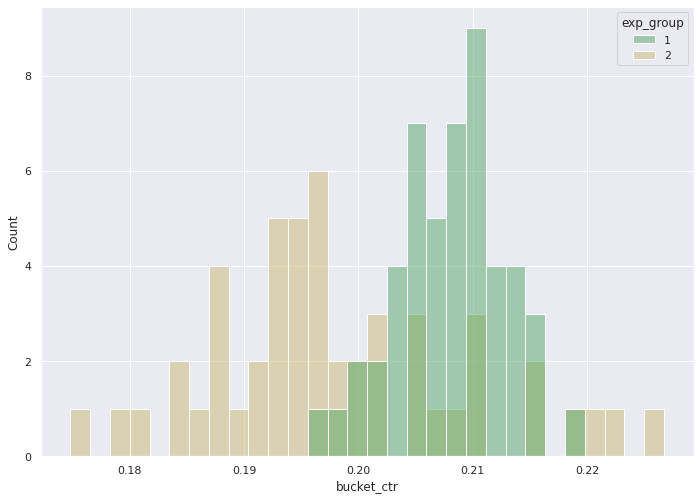

In [24]:
# на графике видно, что CTR экспериментной группы ниже CTR контрольной
sns.histplot(data=users,
            x='bucket_ctr',
            hue='exp_group',
            palette=['g', 'y'],
            alpha=0.5,
            kde=False,
            bins=30)

#### Вывод:

Все тесты, кроме t-теста показали значимые различия (проблема скорее всеро в ненормальном распределении). Также различия хорошо видны на графиках, и не в пользу нового алгоритма, там средний CTR стал ниже.

Но также на графиках видно, что экспериментальная группа как бы поделилась на две: для одной части алгоритм сработал и они стали больше лайкать, вторая часть наоборот взаимодействовала с постами меньше. Нужно выяснить почему так произошло и в чем отличия между этими подгруппами пользователей и доработать алгоритм. Сейчас его раскатывать на всех пользователей не стоит  

# Часть 3: A/B тест методом линеаризованных лайков

Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR

При этом метод сам по себе очень прост. Что это за метрика такая?

- Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
- Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
- После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  

Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже).

Задача:

1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

### Проанализируем тест между группами 1 и 2

In [134]:
# выгружаем данные за период проведения теста
query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220920.feed_actions 
WHERE toDate(time) between '2022-09-03' and '2022-09-09'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

users = ph.read_clickhouse(query, connection=connection)

В качестве контрольной использовалась первая группа

In [135]:
# считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)
ctr_control = users[users.exp_group == 1].likes.sum() / users[users.exp_group == 1].views.sum()
print('Общий CTR в контрольной группе:', round(ctr_control, 3))

Общий CTR в контрольной группе: 0.208


In [136]:
# посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
users['linearized_likes'] = users.likes - ctr_control * users.views 
users.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
0,1,109963,3,15,0.200000,-0.120402
1,1,26117,32,141,0.226950,2.668221
2,1,138232,18,73,0.246575,2.814043
3,1,26295,33,122,0.270492,7.620730
4,1,18392,7,32,0.218750,0.343142


In [137]:
# сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠
stats.ttest_ind(users[users.exp_group == 1].linearized_likes,
                users[users.exp_group == 2].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775973, pvalue=9.439432187037712e-10)

In [138]:
stats.ttest_ind(users[users.exp_group == 1].ctr,
                users[users.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

#### Вывод:

p-value на линеаризированных лайках значительно уменьшился, что позволяет отвергнуть нулевую гипотезу о равенстве CTR

Получилось, что этот метод улучшил t-тест, который не работал из-за бимодального распределения в группе 2

Отличия в распределении CTR можно увидить и на графиках. На гистограме с линеаризированными лайками распределение во 2 группе по-прежнему бимодальное, но различия между "горбами" не такое явное. Получается, что линеаризация повысила чувствительность метрики 

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

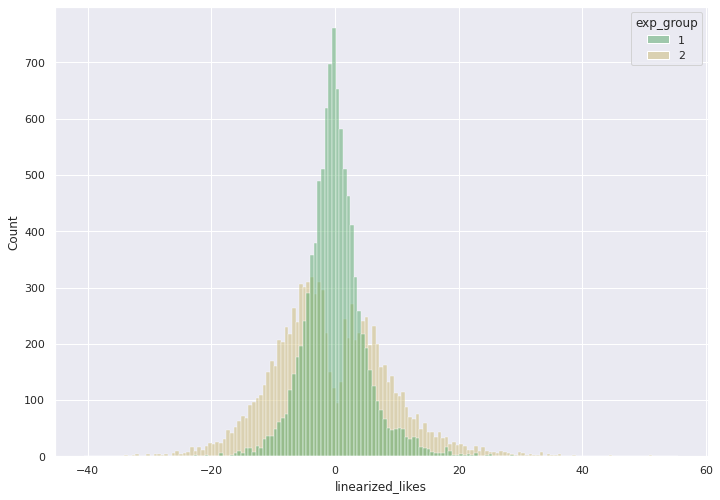

In [139]:
# график распределения линеаризованных лайков
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data = users,
            x='linearized_likes',
            hue='exp_group',
            palette=['g','y'],
            alpha=0.5,
            kde=False)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

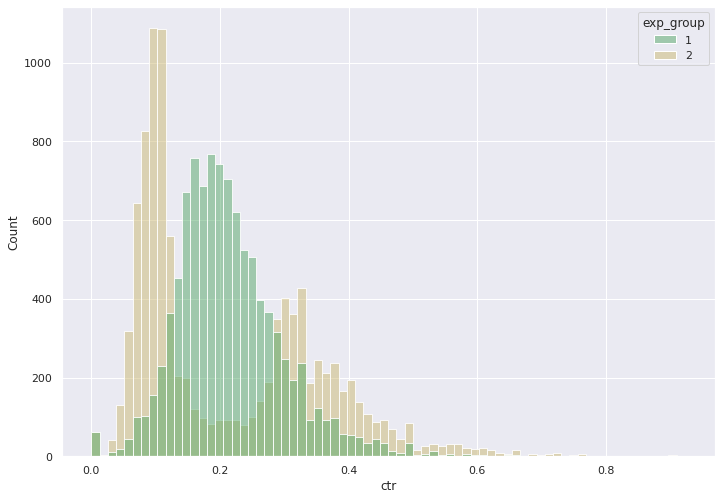

In [140]:
# график распределения CTR
sns.histplot(data = users,
            x='ctr',
            hue='exp_group',
            palette=['g','y'],
            alpha=0.5,
            kde=False)

### Проанализируем тест между группами 0 и 3

In [141]:
# выгружаем данные за период проведения теста
query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220920.feed_actions 
WHERE toDate(time) between '2022-09-03' and '2022-09-09'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
"""

users = ph.read_clickhouse(query, connection=connection)

In [142]:
# считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)
ctr_control = users[users.exp_group == 0].likes.sum() / users[users.exp_group == 0].views.sum()
print('Общий CTR в контрольной группе:', round(ctr_control, 3))

Общий CTR в контрольной группе: 0.208


In [143]:
# посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
users['linearized_likes'] = users.likes - ctr_control * users.views 
users.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
0,3,115383,9,30,0.300000,2.752916
1,3,123580,13,48,0.270833,3.004666
2,0,4944,8,41,0.195122,-0.537681
3,0,4504,5,15,0.333333,1.876458
4,0,121508,18,88,0.204545,-0.324779


In [145]:
# сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠
stats.ttest_ind(users[users.exp_group == 0].linearized_likes,
                users[users.exp_group == 3].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=-15.21499546090383, pvalue=5.4914249479687664e-52)

In [146]:
stats.ttest_ind(users[users.exp_group == 0].ctr,
                users[users.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

#### Вывод:

p-value на линеаризированных лайках значительно уменьшился. В одном и другом тесте результат позволяет отвергнуть нулевую гипотезу

В этом случае t-тест сработал и до преобразования, т.к. распределение изначально было унимодальное и без большого кол-ва выбросов

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

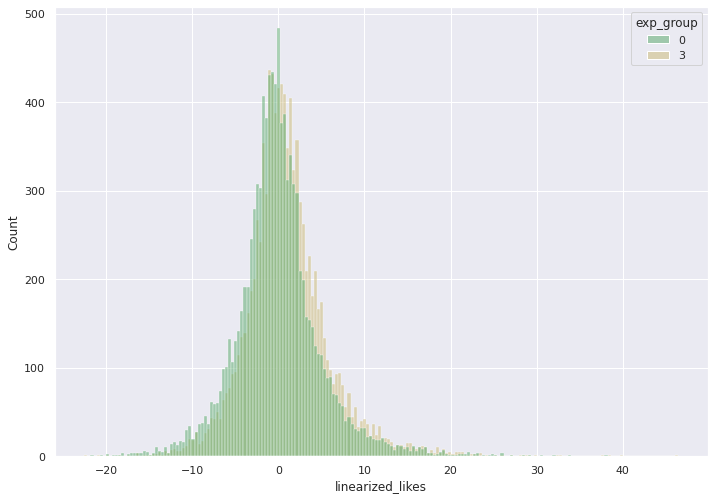

In [147]:
# график распределения линеаризованных лайков
sns.histplot(data = users,
            x='linearized_likes',
            hue='exp_group',
            palette=['g','y'],
            alpha=0.5,
            kde=False)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

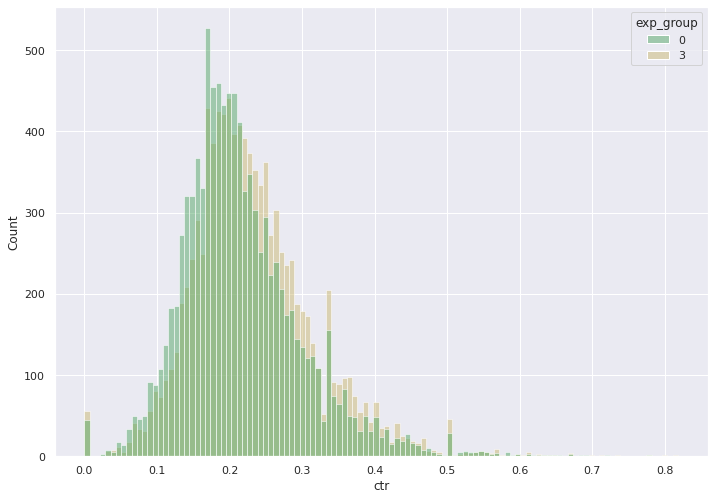

In [148]:
# график распределения CTR
sns.histplot(data = users,
            x='ctr',
            hue='exp_group',
            palette=['g','y'],
            alpha=0.5,
            kde=False)